# Calculate TA using CRMs

This NoteBook shows examples of a workflow that determines the DIC and TA content of samples analysed on a VINDTA 3C (at UEA), and assesses the quality of measurements based on results for the Certified Reference Materials (CRMs) run on each analysis day. 

For questions, contact Elise S. Droste (e.droste@uea.ac.uk)

***
# Introduction

In this NoteBook, total alkalinity (TA) is determined from raw VINDTA data using the Certified Reference Materials runs. 

The quality of the CRM runs is assessed and checked, removing or flagging any questionable CRM runs. The TA content of the samples will be quality checked in the `DICTA_samples_QC_ipynb` NoteBook. 


The dissolved inorganic carbon (DIC) has been processed in a separate script (`DIC_CRMs_QC.ipynb`), the output of which is used in the current NoteBook. 


***
# References

Dickson, 2007, ... 


Humphreys, M. P. and Matthews, R. S. (2021). Calkulate: total alkalinity from titration data in Python. Zenodo. doi:10.5281/zenodo.2634304.



***
# Packages

In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
from dateutil.parser import parse
from IPython.core.interactiveshell import InteractiveShell 

from pathlib import Path

warnings.filterwarnings('ignore') # suppresses warning messages from packages
InteractiveShell.ast_node_interactivity = "all" # allows you to see multiple outputs from a single cell

In [2]:
# import plotly
# plotly.offline.init_notebook_mode(connected=True)

In [3]:
# To see plotly figures in this notebook: 
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'


In [4]:
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
# fig.show()

We use the Python package Calkulate to determine the titrant molality and the TA content. 

Online documentation for Calkulate: https://calkulate.hseao3.group/

In [5]:
import calkulate as calk # Version >= 23 
calk.hello()


   .--.     . .         .      .      
  :         | |         |     _|_     
  |    .-.  | |.-. .  . | .-.  |  .-. 
  :   (   ) | |-.' |  | |(   ) | (.-' 
   `--'`-'`-`-'  `-`--`-`-`-'`-`-'`--'

       doi:10.5281/zenodo.2634304
       
             Version 23.1.0



***
# Modules

`calc_TA` is a module that uses a Class containing functions for the total alkalinity data processing. It ensures consistent processing and formatting of the data. Import here. Classes are created after the data has been imported. 

In [6]:
from UEA_VINDTA_pkg.calc_TA import CalcTA

Hello! Before running the CalcTA Class, make sure the filenames of the runs are correct and DIC has been calculated.
Imported crmbatch script.
Imported CalcTA class.


The classes and their methods use the column names given in `column_names.py`. 

In [8]:
from UEA_VINDTA_pkg import column_names

***
# Import Data

eThe imported data has already been processed for DIC in `DIC_CRMs_QC.ipynb`. In addition, it has been checked for filenaming mistakes, sample temperature corrections, and aborted runs (for which there is no data) have been removed in `DICTA_fileprep.ipynb`. 

In [10]:
datadir = Path("../output_data/DIC_calculated/")
datafile = "dic_prelim_20250109.csv" 

vindta_data = pd.read_csv(Path(datadir) / datafile, na_values = -999) 

***
# Create Classes

## Class

Create the classes that will be using the DIC concentrations that have been determined using CRM averages per DIC cell instead of all cells per instrument. 

In [11]:
vindta = CalcTA(vindta_data)

sampling_date found in the columns of the DataFrame. Make sure it's correctly populated, i.e. not empty.
Check that nuts are given!


***
# Assign HCl Batches

A function within the Class will assign an acid batch based on a list of dates OR a list of DIC cells. If only 1 acid batch was used from beginning to end of the analysis period, then this list can contain just the date/cell of the first day of analysis. If the acid batch was changed or topped up, add the dates/cells when this was done to the list and also include the last date/cell of analysis. 

The Class will have converted the `Date (analysis)` and `analysis_datetime` columns to DateTime objects. 

If using dates, the dates in the list need to be in `%Y-%m-%d` format!! 

In [12]:
# List with dates when acid batch was changed (including the first and last day in the file) in format yyyy-mm-dd
acidbatches_dates = ["2024-01-18", "2024-01-31", "2024-02-07", "2024-02-11", "2024-02-16", "2024-03-09"] # UPDATE THE LAST DATE IN THE LIST
# List with cells when acid batch was changed (including the first one and using 100 as the last one to make sure none are excluded)
acidbatches_cells = [1, 7, 12, 20, 100] # UPDATE THE LAST CELL IN THE LIST


In [13]:
vindta.assign_acidbatch_(acidbatchlist = acidbatches_cells, use = "cells")

***
# Pipette Volumes

Pipette calibrations have been checked in `DICTA_fileprep.ipynb`. Have a look there if you need to check something. 

In [14]:
# Length of the following arrays should all be 1!
vindta_data["DIC pipette volume (ml)"].unique()
vindta_data["TA pipette vol (ml)"].unique()

array([21.8442])

array([96.7556])

***
# Remove faulty CRM TA runs

Here, remove any faulty CRM runs that have already been identified in the lab. 

In [15]:
remove_these_crm_rows = [] # add filenames (strings) in list, e.g. "8888_0208_0168_0_1_1", "8888_0208_0168_0_1_2"

# Drop for each of the classes
vindta.df_ta = vindta.df_ta.loc[~vindta.df_ta["Sample Name"].isin(remove_these_crm_rows)].reset_index(drop = True)

***
# Prepare MetaData

Calkulate is used to determine the HCl concentration (acid calibration) and subsequently the TA concentration (see below). The modules need a DataFrame with all the required meta-data as input. The module will create a default DataFrame, but a dataframe (manually created) can also be given. 

Check the following docs for info on the required metadata input: https://calkulate.readthedocs.io/en/latest/metadata/#dataset-column-names


Refs: Humphreys, M. P. and Matthews, R. S. (2021). Calkulate: total alkalinity from titration data in Python. Zenodo. doi:10.5281/zenodo.2634304.

In [22]:
datfile_dir = "/Users/eldros001/ED_Science" + "/UEA_VINDTA_DATA_PROCESSING/rawdata/" # This needs to be an absolute directory path, not a relative one. To find it, run the line below. 
vindta.create_calk_dict(path_to_datfiles = datfile_dir, calk_dict = "default")
vindta.create_calk_ds() 
vindta.ds_ta_calk


Using dic_sample_umol_per_kg to calculate TA. Can be changed in column_names file if necessary.
Find DataFrame as self.ds_ta_calk - to be used in TA calculations. Edit if necessary. 


,file_name,salinity,analyte_volume,alkalinity_certified,analysis_batch,dic,file_path,total_silicate,total_phosphate
0,8888_208_1208_0_1_1.dat,33.1400,96.7556,2215.76,1.0,2059.660000,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,3.3,0.58
1,8888_208_1208_0_1_2.dat,33.1400,96.7556,2215.76,1.0,2059.660000,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,3.3,0.58
2,0000_003_6_356_1_1.dat,34.6034,96.7556,NaN,1.0,2249.843927,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
3,0000_003_6_356_2_1.dat,34.6034,96.7556,NaN,1.0,2246.986505,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
4,0000_003_2_456_1_1.dat,34.6246,96.7556,NaN,1.0,2250.123120,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
...,...,...,...,...,...,...,...,...,...
498,6666_202402090717_8_350_1_1.dat,34.6800,96.7556,NaN,4.0,2201.072531,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
499,6666_202402140707_11_350_1_1.dat,34.6800,96.7556,NaN,4.0,2201.871534,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
500,6666_202402161917_14_350_1_1.dat,34.6800,96.7556,NaN,4.0,2207.939937,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,0.0,0.00
501,8888_208_0278_0_1_1.dat,33.1400,96.7556,2215.76,4.0,2059.660000,/Users/eldros001/ED_Science/VINDTA_DATA_PROCES...,3.3,0.58


In [23]:
%%bash

cd ../rawdata/

pwd

/Users/eldros001/ED_Science/VINDTA_DATA_PROCESSING/rawdata


<font color=orange> Note: the module and Class are designed so that you can also manually construct a dictionary for Calkulate. Look into `calc_TA.py` on how to do that </font>

***
# HCl Concentration

Calibrate titrant molinity using the Calkulate package. Note that here we're working with Version 23! 



"For each titration (i.e. row in the Dataset) that has an alkalinity_certified value, this method determines the titrant molinity (in mol/kg-solution) that is required for the titration to return its certified alkalinity value. This is stored in a new column in the Dataset called titrant_molinity_here.

Then, the titrant_molinity_here values are averaged — by analysis_batch if provided, or over the entire Dataset if not — and stored in a new column called titrant_molinity." (Humphreys&Matthews, 2021)

In [24]:
# ds = calk.calkulate(ds)
# vindta.ds_ta_calk.calkulate() # in place

In [25]:
vindta.hcl_conc()


Calkulate: calibrating titrant_molinity...
Calkulate: calibration complete!
Standard deviation per batch also calculated.
Find calibrated titrant data added to self.ds_ta_calk DataFrame :) 


In [26]:
vindta.plot_hcl_conc()

Figure saved as self.plot_hcl_conc_fig


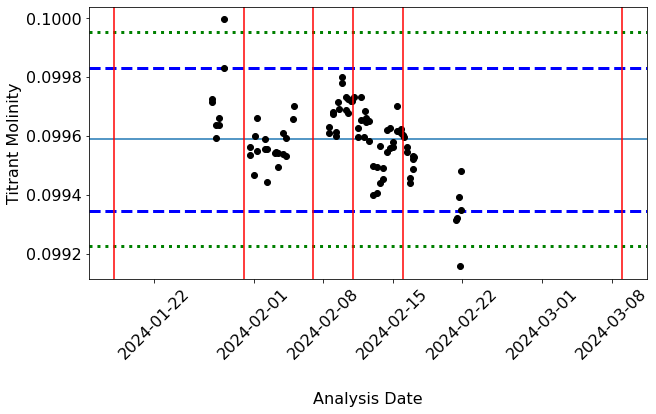

In [27]:
fig = plt.figure(figsize = (10, 5))
ax0 = fig.add_subplot(111)

ax0.scatter(vindta.df_ta["analysis_datetime"], vindta.ds_ta_calk["titrant_molinity_here"], c = "k")

molinity_mean = np.nanmean(vindta.ds_ta_calk["titrant_molinity_here"])
molinity_std = np.nanstd(vindta.ds_ta_calk["titrant_molinity_here"])

ax0.axhline(y = molinity_mean, zorder = 0)
ax0.axhline(y = molinity_mean + 2*molinity_std, c = "b", ls = "--", lw = 3, zorder = 0)
ax0.axhline(y = molinity_mean - 2*molinity_std, c = "b", ls = "--", lw = 3, zorder = 0)
ax0.axhline(y = molinity_mean + 3*molinity_std, c = "g", ls = ":", lw = 3, zorder = 0)
ax0.axhline(y = molinity_mean - 3*molinity_std, c = "g", ls = ":", lw = 3, zorder = 0)

# add dates of batch changes
for d in acidbatches_dates:
    ax0.axvline(pd.to_datetime(d), c = "r")

ax0.tick_params(axis = "x", labelsize = 16, labelrotation = 45)
ax0.tick_params(axis = "y", labelsize = 16)

ax0.set_ylabel("Titrant Molinity", fontsize = 16)
ax0.set_xlabel("Analysis Date", fontsize = 16, labelpad = 30);

In [28]:
vindta.ds_ta_calk["titrant_molinity_here"].describe()

count    89.000000
mean      0.099589
std       0.000122
min       0.099158
25%       0.099532
50%       0.099598
75%       0.099661
max       0.099996
Name: titrant_molinity_here, dtype: float64

***
# Preliminary TA Determination

"For each titration (i.e. row in the Dataset) that has an titrant_molinity value (e.g. as generated by ds.calibrate() above), this method determines its total alkalinity in μmol/kg-solution. The results are stored in a new column in the Dataset called alkalinity." (Humphreys&Matthews, 2021)
 

In [29]:
# ds.solve()

<font color=orange> Titrant molinity is per batch. 

In [30]:
# vindta.ds_ta_calk.solve()
vindta.calc_ta()


Calkulate: solving alkalinity...
Calkulate: ERROR solving '0000_019_21_6_1_1.dat'!
Calkulate: ERROR solving '0000_036_4_300_3_1.dat'!
Calkulate: ERROR solving '0000_039_20_5_1_1.dat'!
Calkulate: ERROR solving '0000_087_20_17_1_1.dat'!
Calkulate: solving complete!


In [31]:
vindta.ta_x_chart()

Figure saved as self.ta_x_chart_fig


In [32]:
vindta.df_ta["alkalinity_umolkg"][vindta.df_ta["Station"]==8888].describe()

count      89.000000
mean     2215.793876
std         2.019884
min      2209.857644
25%      2214.528266
50%      2215.803699
75%      2216.679983
max      2221.838282
Name: alkalinity_umolkg, dtype: float64

***
# Remove/flag CRMs

Here, remove any other CRMs or flag them if necessary. If you remove them, re-do the calculations above. 

***
# Save the data

In [33]:
prelim_datadir = Path("../output_data/DICTA_calculated/")
prelim_datafile = "dicta_prelim_" + datetime.date.today().strftime(format = "%Y%m%d") + ".csv"
vindta.df_ta.to_csv(prelim_datadir / prelim_datafile, index = False)

:)